### Loading Required Libraries 

The following libraries are imported to perform various tasks related to data processing, medical imaging, and building deep learning models:

#### 1. **Pandas (`pd`)**
   - Used for handling and analyzing structured data, especially in tabular format. 
   - Provides powerful tools for data manipulation and analysis.

#### 2. **NumPy (`np`)**
   - A fundamental package for scientific computing in Python.
   - Used here for numerical operations and handling arrays efficiently.

#### 3. **Pydicom (`pydicom`)**
   - A library to read, write, and manipulate DICOM (Digital Imaging and Communications in Medicine) files.
   - Commonly used for medical imaging tasks.

#### 4. **OpenCV (`cv2`)**
   - A library for image processing and computer vision.
   - Used for tasks like reading, modifying, and saving images.

#### 5. **OS (`os`)**
   - Provides functions to interact with the operating system, such as navigating directories and handling file paths.

#### 6. **Zipfile (`zipfile`)**
   - Used to read and write `.zip` archive files, enabling the compression and decompression of data.

#### 7. **TensorFlow Keras (`tensorflow.keras`)**
   - TensorFlow is a popular deep learning library, and Keras is its high-level API for building neural networks.

   #### Submodules imported:
   - **`Sequential`**:
     - A linear stack of layers used to build a simple feedforward model.
   - **`Conv2D`**:
     - A convolutional layer


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import pydicom
import cv2
import os
import zipfile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### Extract ZIP File

1. **Extracting the ZIP file**: 
   - The dataset is extracted from a ZIP file located at `zip_file_path` to the directory `extract_dir`.
   
2. **Defining image directories**: 
   - Paths for the **training** and **test image directories** are defined (`train_image_dir` and `test_image_dir`).

3. **Loading CSV files**: 
   - The script loads metadata CSV files containing **labels** and **class information** using **Pandas** (`train_labels` and `class_info`).

4. **Creating directories for dataset split**: 
   - New directories for **train** and **test datasets** (`split_train_dir` and `split_test_dir`) are created to organize images into training and testing sets.

The dataset is now organized and ready for further **preprocessing** and **model training**.


In [2]:
import os
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil

# Define paths for ZIP file and extracted content
zip_file_path = "rsna-pneumonia-detection-challenge.zip"
extract_dir = "dataset"

# Step 1: Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Data extracted to: {extract_dir}")

# Step 2: Define image directories
train_image_dir = os.path.join(extract_dir, "stage_2_train_images")
test_image_dir = os.path.join(extract_dir, "stage_2_test_images")

# Step 3: Load CSV files
train_labels = pd.read_csv(os.path.join(extract_dir, "stage_2_train_labels.csv"))
class_info = pd.read_csv(os.path.join(extract_dir, "stage_2_detailed_class_info.csv"))

# Step 4: Create directories for split datasets
split_train_dir = os.path.join(extract_dir, "split_train_images")
split_test_dir = os.path.join(extract_dir, "split_test_images")
os.makedirs(split_train_dir, exist_ok=True)
os.makedirs(split_test_dir, exist_ok=True)

# Step 5: Get unique image IDs from train_labels
image_ids = train_labels['patientId'].unique()

# Step 6: Split image IDs into 80% training and 20% testing
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

# Step 7: Filter train_labels DataFrame for train and test splits
train_data = train_labels[train_labels['patientId'].isin(train_ids)]
test_data = train_labels[train_labels['patientId'].isin(test_ids)]

# Save the filtered train and test data to CSV files
split_train_csv_path = os.path.join(extract_dir, "split_train_data.csv")
split_test_csv_path = os.path.join(extract_dir, "split_test_data.csv")
train_data.to_csv(split_train_csv_path, index=False)
test_data.to_csv(split_test_csv_path, index=False)

print(f"Train data saved to: {split_train_csv_path}")
print(f"Test data saved to: {split_test_csv_path}")

# Step 8: Function to copy images to respective directories
def copy_images(image_ids, source_dir, destination_dir):
    for image_id in image_ids:
        image_file = f"{image_id}.dcm"  # Adjust extension if images are not in .dcm format
        src_path = os.path.join(source_dir, image_file)
        dst_path = os.path.join(destination_dir, image_file)
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"File {image_file} not found in {source_dir}")

# Step 9: Copy images for train and test sets
copy_images(train_ids, train_image_dir, split_train_dir)
copy_images(test_ids, train_image_dir, split_test_dir)

print(f"Training images copied to: {split_train_dir}")
print(f"Testing images copied to: {split_test_dir}")


Data extracted to: dataset
Train data saved to: dataset/split_train_data.csv
Test data saved to: dataset/split_test_data.csv
Training images copied to: dataset/split_train_images
Testing images copied to: dataset/split_test_images


### Preprocess images for clustering

1. **Load and Preprocess DICOM Image**:
   - The function `load_and_preprocess_dicom(filepath, img_size=(224, 224))` is used to load and preprocess DICOM images.
     - **Loading the DICOM file**: The image is loaded using `pydicom.dcmread(filepath)`.
     - **Extracting pixel array**: The pixel data of the DICOM image is extracted (`dicom.pixel_array`).
     - **Resizing the image**: The image is resized to a target size (`img_size=(224, 224)`) using OpenCV (`cv2.resize`).
     - **Normalizing pixel values**: The image pixel values are scaled to the range [0, 1] by dividing by 255.
     - **Expanding dimensions**: The image is reshaped by adding a channel dimension for grayscale images using `np.expand_dims(img, axis=-1)`.

2. **Combining Bounding Boxes for Train Data**:
   - **Group by `patientId`**: The training data (`train_data`) is grouped by `patientId` to aggregate bounding box information (`x`, `y`, `width`, `height`) and the **maximum** `Target` value.
   - **Has pneumonia column**: A new column `has_pneumonia` is added, which is `True` if the `Target` value is greater than 0.

3. **Combining Bounding Boxes for Test Data**:
   - Similar to the train data, the test data (`test_data`) is grouped by `patientId` and bounding box data is aggregated.
   - A new column `has_pneumonia` is added based on the `Target` value, indicating the presence of pneumonia.

DICOM images are preprocessed for model input, and both train and test datasets are aggregated and ready for further analysis or model training.


In [3]:
def load_and_preprocess_dicom(filepath, img_size=(224, 224)):
    """Load and preprocess a DICOM image."""
    dicom = pydicom.dcmread(filepath)
    img = dicom.pixel_array
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalize pixel values
    return np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale

# Combine bounding boxes for the same patientId for train data
train_data = train_data.groupby("patientId").agg({
    "x": list, "y": list, "width": list, "height": list, "Target": "max"
}).reset_index()
train_data["has_pneumonia"] = train_data["Target"] > 0

# Combine bounding boxes for the same patientId for test data
test_data = test_data.groupby("patientId").agg({
    "x": list, "y": list, "width": list, "height": list, "Target": "max"
}).reset_index()
test_data["has_pneumonia"] = test_data["Target"] > 0



### Data Generator for Cluster Batch Processing python

1. **Class Initialization (`__init__`)**:
   - The `PneumoniaDataGenerator` is initialized with the following parameters:
     - **`dataframe`**: Contains image metadata and labels (e.g., bounding boxes, class labels).
     - **`img_dir`**: Directory containing DICOM images.
     - **`batch_size`**: Number of samples to return in each batch.
     - **`img_size`**: Target image size for resizing (default is `(224, 224)`).

2. **Length of the Dataset (`__len__`)**:
   - The `__len__` method calculates the total number of batches per epoch based on the size of the dataset and the specified `batch_size`.

3. **Get a Batch of Data (`__getitem__`)**:
   - The `__getitem__` method generates a single batch of data:
     - It selects a batch of rows from the `dataframe`.
     - **Image and label lists** are initialized.
     - For each image, the method loads and preprocesses the corresponding DICOM image (the code for loading is truncated but likely uses `load_and_preprocess_dicom`).


In [4]:
from tensorflow.keras.utils import Sequence

class PneumoniaDataGenerator(Sequence):
    def __init__(self, dataframe, img_dir, batch_size, img_size=(224, 224)):
        """
        Initialize the data generator.
        :param dataframe: DataFrame containing image metadata and labels.
        :param img_dir: Directory containing DICOM images.
        :param batch_size: Number of samples per batch.
        :param img_size: Target image size for resizing (width, height).
        """
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.img_size = img_size
    
    def __len__(self):
        """
        Calculate the number of batches per epoch.
        """
        return int(np.ceil(len(self.dataframe) / self.batch_size))
    
    def __getitem__(self, index):
        """
        Generate a single batch of data.
        """
        batch_data = self.dataframe.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        labels = []
        for _, row in batch_data.iterrows():
            # Use load_and_preprocess_dicom to load and preprocess each image
            img_path = os.path.join(self.img_dir, f"{row['patientId']}.dcm")
            img = load_and_preprocess_dicom(img_path, self.img_size)
            images.append(img)
            labels.append(row["has_pneumonia"])  # Binary classification: 1 for pneumonia, 0 for no pneumonia
        return np.array(images), np.array(labels) 

    
# Initialize generators
train_generator = PneumoniaDataGenerator(train_data, train_image_dir, batch_size=32)


### Define the CNN Model

The CNN incorporates **regularization techniques**, **dropout layers**, and **batch normalization** to improve model performance and generalization.

1. **CNN Architecture (`build_cnn`)**:
   - **Input Shape**: The model expects images of shape `(224, 224, 1)` (grayscale images resized to 224x224 pixels).
   - **Layers**:
     1. **Convolutional Layers (`Conv2D`)**:
        - Extract features from input images using 3x3 kernels.
        - The `l2` regularization is applied to weights to prevent overfitting.
     2. **Batch Normalization**:
        - Normalizes activations, accelerating training and improving stability.
     3. **MaxPooling Layers (`MaxPooling2D`)**:
        - Reduces spatial dimensions, retaining key features.
     4. **Dropout**:
        - Randomly deactivates neurons during training to reduce overfitting.
     5. **Flatten Layer**:
        - Converts 2D feature maps into a 1D vector for the fully connected layers.
     6. **Dense Layers**:
        - Includes a hidden layer with 128 neurons and an output layer with 1 neuron using a **sigmoid activation** for binary classification.

2. **Compilation**:
   - **Optimizer**: Adam optimizer with a learning rate of `0.0001` is used for efficient weight updates.
   - **Loss Function**: `binary_crossentropy` is selected for binary classification.
   - **Metrics**: Accuracy is used to evaluate model performance.

3. **Model Summary**:
   - The `model.summary()` function displays the architecture, including the number of trainable parameters and layer configurations.

    Features of the CNN:
        - **Regularization**:
            - Uses `l2` regularization to penalize large weights, reducing overfitting.
        - **Dropout**:
            - Dropout rates (`0.25` and `0.5`) are applied after key layers for additional regularization.
        - **Batch Normalization**:
            - Ensures consistent learning by stabilizing the inputs to each layer.

4. **Output**:
   - The model outputs a single neuron with a sigmoid activation function, predicting the probability of pneumonia presence (1 for pneumonia, 0 otherwise).


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

# Define an updated CNN architecture with regularization, dropout, and batch normalization
def build_cnn(input_shape=(224, 224, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=input_shape, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),  # Dropout for regularization
        
        Conv2D(64, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Flatten(),
        Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(1, activation="sigmoid")  # Binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    return model

model = build_cnn()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     2

### Callbacks

1. **Directory for Saving Models**:
   - The directory where the trained models will be stored is defined as:
     ```python
     persistent_model_dir = "models"
     ```
   - Models are saved in the directory during training based on specified conditions.

2. **Callbacks**:
   - A list of callbacks is created to enhance the training process:
     
     #### a. **ModelCheckpoint**:
     - Saves the best version of the model based on **validation loss** (`val_loss`).
     - **Parameters**:
       - `filepath`: Path to save the best model (`best_model.keras`).
       - `save_best_only=True`: Ensures only the best model is saved.
       - `monitor="val_loss"`: Monitors the validation loss to determine the best model.
       - `verbose=1`: Prints updates about saving the model.

     #### b. **EarlyStopping**:
     - Stops training early if the validation loss stops improving to avoid overfitting.
     - **Parameters**:
       - `monitor="val_loss"`: Monitors validation loss.
       - `patience=5`: Waits for 5 epochs with no improvement before stopping.
       - `restore_best_weights=True`: Restores the model weights to the best observed during training.
       - `verbose=1`: Provides updates when training stops.

     #### c. **ReduceLROnPlateau**:
     - Reduces the learning rate when the validation loss stops improving, helping the model converge.
     - **Parameters**:
       - `monitor="val_loss"`: Monitors validation loss.
       - `factor=0.5`: Reduces the learning rate by half when triggered.
       - `patience=3`: Waits for 3 epochs with no improvement before reducing the learning rate.
       - `min_lr=1e-6`: Ensures the learning rate does not fall below this value.
       - `verbose=1`: Prints updates about learning rate changes.

#### Features of the Callbacks:
- **ModelCheckpoint** ensures the best model is saved.
- **EarlyStopping** prevents overtraining, saving time and improving generalization.
- **ReduceLROnPlateau** dynamically adjusts the learning rate to optimize training.

#### Use Case:
These callbacks are integrated into the model training process to improve efficiency and ensure optimal model performance.


In [6]:
# Define the directory
persistent_model_dir = "models"

# Define callbacks
callbacks = [
    ModelCheckpoint(
        filepath=os.path.join(persistent_model_dir, "best_model.keras"),
        save_best_only=True,
        monitor="val_loss",
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]


### Train the model on the cluster

1. **Dataset Splitting**:
   - The dataset is split into **training** and **validation** sets:


2. **Data Generators**:
   - `PneumoniaDataGenerator` is used to preprocess data in batches for training and validation:


3. **Model Saving Path**:
   - The best-performing model is saved at: persistent_model_dir


4. **Callbacks**:
   - **ModelCheckpoint** saves the model with the lowest validation loss.
   - **EarlyStopping** halts training if validation loss does not improve for 5 epochs.


5. **Model Training**:
   - The model is trained for up to 50 epochs with validation monitoring:


Output:
- The **best model** is saved automatically and its path is printed.


In [8]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Split the dataset into train and validation sets
train_data_split, val_data_split = train_test_split(train_data, test_size=0.2, random_state=42)

# Initialize generators for training and validation
train_generator = PneumoniaDataGenerator(train_data_split, train_image_dir, batch_size=32)
val_generator = PneumoniaDataGenerator(val_data_split, train_image_dir, batch_size=32)

# Define the path for saving the best model
persistent_model_dir = f"models/"  
os.makedirs(persistent_model_dir, exist_ok=True)
model_checkpoint_path = os.path.join(persistent_model_dir, "best_model.keras")  

# Define callbacks
callbacks = [
    ModelCheckpoint(model_checkpoint_path, save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1)
]

# Train the model with train and validation sets
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)

print(f"Best model saved at: {model_checkpoint_path}")


Epoch 1/50
534/534 [==============================] - 644s 1s/step - loss: 0.7510 - accuracy: 0.7855 - val_loss: 1.0093 - val_accuracy: 0.7714
Epoch 2/50
534/534 [==============================] - 669s 1s/step - loss: 0.7191 - accuracy: 0.7898 - val_loss: 0.7923 - val_accuracy: 0.7787
Epoch 3/50
534/534 [==============================] - 642s 1s/step - loss: 0.6840 - accuracy: 0.7950 - val_loss: 0.9955 - val_accuracy: 0.7738
Epoch 4/50
534/534 [==============================] - 583s 1s/step - loss: 0.6622 - accuracy: 0.8034 - val_loss: 0.7179 - val_accuracy: 0.7813
Epoch 5/50
534/534 [==============================] - 703s 1s/step - loss: 0.6443 - accuracy: 0.8059 - val_loss: 0.6822 - val_accuracy: 0.7862
Epoch 6/50
534/534 [==============================] - 682s 1s/step - loss: 0.6239 - accuracy: 0.8098 - val_loss: 0.8964 - val_accuracy: 0.7754
Epoch 7/50
534/534 [==============================] - 605s 1s/step - loss: 0.6176 - accuracy: 0.8129 - val_loss: 0.9156 - val_accuracy: 0.7855

#### Plotting the learning curve

1. **Extract Metrics**:
- Retrieves the training and validation loss, as well as accuracy values, from the model's training history.

2. **Plot Training and Validation Loss**:
- A line plot is created to compare the training loss and validation loss across all epochs.
- The plot includes a title, axis labels, a legend to distinguish between training and validation curves, and a grid for readability.

3. **Plot Training and Validation Accuracy**:
- A similar line plot is generated to visualize the training accuracy and validation accuracy across epochs.
- This plot also includes a title, axis labels, a legend, and a grid.

4. **Visualization Features**:
- Titles like "Learning Curve: Loss" and "Learning Curve: Accuracy" provide clear context for the plots.
- The x-axis represents epochs, and the y-axis shows the corresponding metric values.
- Legends and color distinctions are used to differentiate between training and validation metrics.

These visualizations help analyze model performance, highlighting potential overfitting, underfitting, or good generalization by comparing the training and validation metrics.


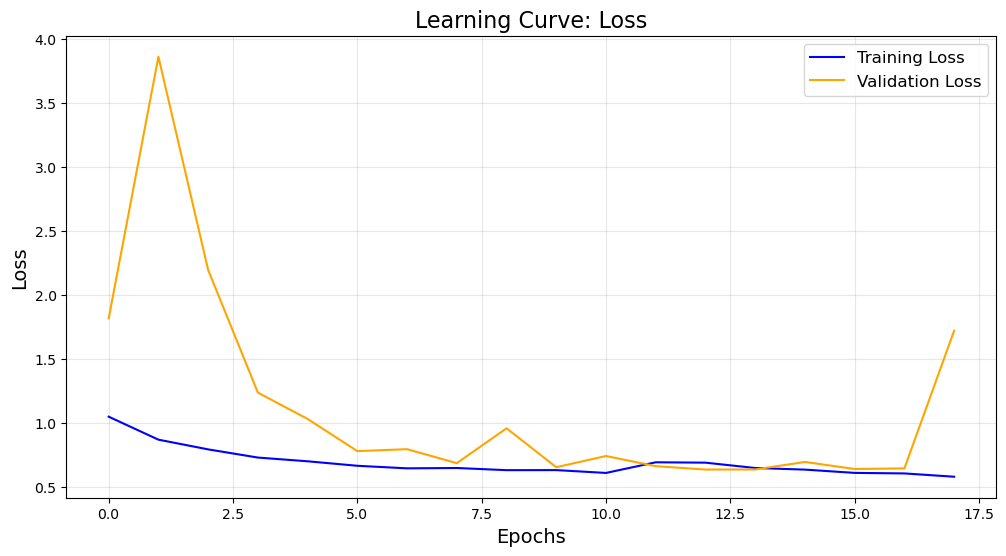

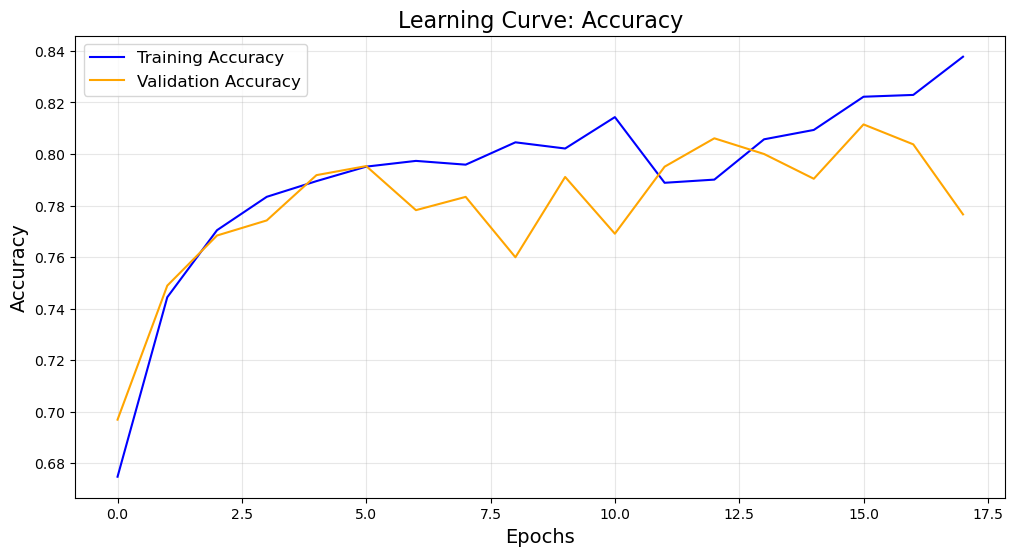

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values from the training history
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label="Training Loss", color="blue")
plt.plot(val_loss, label="Validation Loss", color="orange")
plt.title("Learning Curve: Loss", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label="Training Accuracy", color="blue")
plt.plot(val_accuracy, label="Validation Accuracy", color="orange")
plt.title("Learning Curve: Accuracy", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()


### Making predictions using the model

1. **Load the Best Model**:
- The best model's weights are loaded from a checkpoint file. If the file is missing, an error is raised.
- Ensures the model is ready for predictions with the optimal parameters.

2. **Filter Missing Files**:
- A function filters out rows in the test dataset where corresponding DICOM files are missing.
- Valid patient IDs are determined by matching entries in the dataset with files present in the test image directory.
- This ensures predictions are only made on valid test samples.

3. **Load Test Data**:
- The test data CSV is loaded, containing metadata for the test set. If the file is not found, an error is raised.
- The script ensures the `has_pneumonia` column is present in the test dataset. If missing, it is computed based on the `Target` value.

4. **Filter Test Data**:
- After filtering, the script checks whether valid test data remains. If no valid data is found, an error is raised.

5. **Test Data Generator**:
- A `PneumoniaDataGenerator` is created to preprocess and batch the test data for predictions.

6. **Model Predictions**:
- The model makes predictions on the test data generator.
- Predictions are output to evaluate the model's performance on the test dataset.

#### Purpose:
This code ensures that the test data is valid, preprocesses it for evaluation, and utilizes the trained model to generate predictions, facilitating model assessment on unseen data.


In [ ]:
import os
import pandas as pd

# Load the best model
model_checkpoint_path = "models/best_model.keras"
if os.path.exists(model_checkpoint_path):
    model.load_weights(model_checkpoint_path)
    print(f"Model loaded successfully from {model_checkpoint_path}")
else:
    raise FileNotFoundError(f"Model checkpoint not found at {model_checkpoint_path}")

# Function to filter out rows with missing DICOM files
def filter_missing_files(dataframe, image_dir):
    """
    Filters out rows from the dataframe where the corresponding DICOM file is missing.
    :param dataframe: DataFrame containing image metadata.
    :param image_dir: Directory containing DICOM images.
    :return: Filtered DataFrame with valid patient IDs.
    """
    valid_ids = [f.split(".")[0] for f in os.listdir(image_dir)]  # Extract available file IDs
    filtered_data = dataframe[dataframe["patientId"].isin(valid_ids)]
    print(f"Filtered test data: {len(filtered_data)} valid records found.")
    return filtered_data

# Path to the test image directory
test_image_dir = "dataset/split_test_images"

# Path to the test data CSV (generated during train-test split)
test_data_csv_path = "dataset/split_test_data.csv"

# Load the test data CSV
if os.path.exists(test_data_csv_path):
    test_data = pd.read_csv(test_data_csv_path)
    print(f"Test data loaded successfully from {test_data_csv_path}")
else:
    raise FileNotFoundError(f"Test data CSV not found at {test_data_csv_path}")

# Ensure `has_pneumonia` column exists
if "has_pneumonia" not in test_data.columns:
    test_data = test_data.groupby("patientId").agg({
        "x": list, "y": list, "width": list, "height": list, "Target": "max"
    }).reset_index()
    test_data["has_pneumonia"] = test_data["Target"] > 0

# Filter out rows with missing files
test_data = filter_missing_files(test_data, test_image_dir)

# Check if valid test data exists after filtering
if len(test_data) == 0:
    raise ValueError("No valid test data found after filtering for missing files.")

# Define the test generator
test_generator = PneumoniaDataGenerator(test_data, test_image_dir, batch_size=32)

# Predict on test data
predictions = model.predict(test_generator)

# Output predictions
print("Predictions:")
print(predictions)


Model loaded successfully from /Users/shashwathkumar/VScode/REENA/modelOptimization/models/best_model.keras
Test data loaded successfully from /Users/shashwathkumar/VScode/REENA/dataset/split_test_data.csv
Filtered test data: 5337 valid records found.
167/167 [==============================] - 40s 235ms/step
Predictions:
[[0.12576224]
 [0.04743452]
 [0.09031815]
 ...
 [0.03397167]
 [0.13208573]
 [0.46167907]]


#### Evaluating the model's performance

1. **Threshold Adjustment**:
- The predictions (probabilities) are evaluated against multiple thresholds ranging from 0 to 1.
- For each threshold:
  - The predicted classes are determined based on whether probabilities exceed the threshold.
  - Accuracy is calculated and plotted against thresholds to determine the optimal threshold.

2. **Performance Metrics**:
- After selecting an optimal threshold (e.g., 0.5), the following metrics are generated:
  - **Confusion Matrix**: Displays counts of true positives, true negatives, false positives, and false negatives.
  - **Classification Report**: Provides precision, recall, F1-score, and support for each class.

3. **Visualization**:
- **Accuracy vs. Threshold Plot**:
  - Illustrates how accuracy varies with different thresholds to assist in selecting an optimal cutoff.
- **Confusion Matrix Heatmap**:
  - Visualizes the confusion matrix for easy interpretation.
  - Color-coded to highlight counts of correct and incorrect classifications.
- **ROC Curve and AUC**:
  - The ROC curve plots the true positive rate (TPR) vs. false positive rate (FPR) for various thresholds.
  - The AUC (Area Under the Curve) quantifies the model's ability to distinguish between classes.


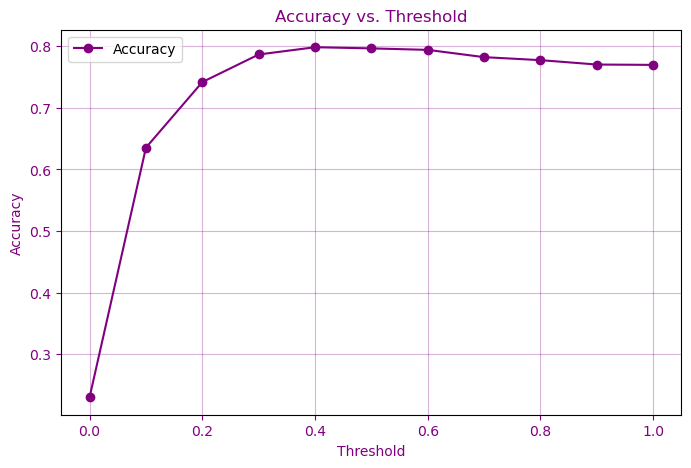

Confusion Matrix:
[[3841  267]
 [ 819  410]]

Classification Report:
              precision    recall  f1-score   support

No Pneumonia       0.82      0.94      0.88      4108
   Pneumonia       0.61      0.33      0.43      1229

    accuracy                           0.80      5337
   macro avg       0.71      0.63      0.65      5337
weighted avg       0.77      0.80      0.77      5337



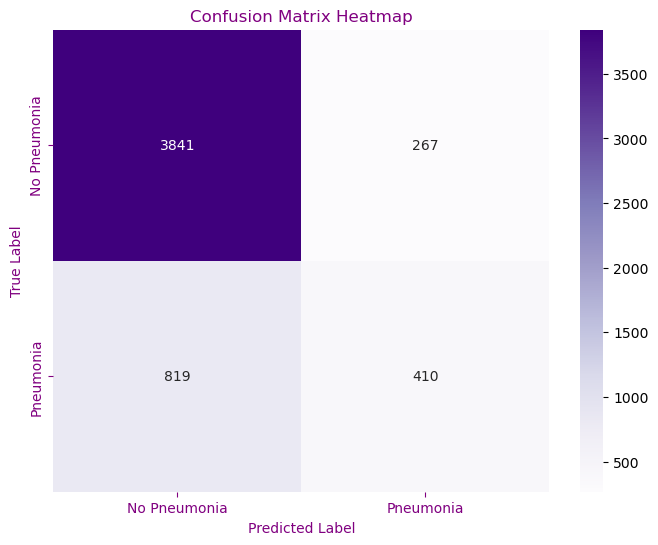

/var/folders/43/6fvj434j2qjfvdnjgd1n535r0000gn/T/ipykernel_47710/4209317232.py:62: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", label="Random Guess", color="lightgray")


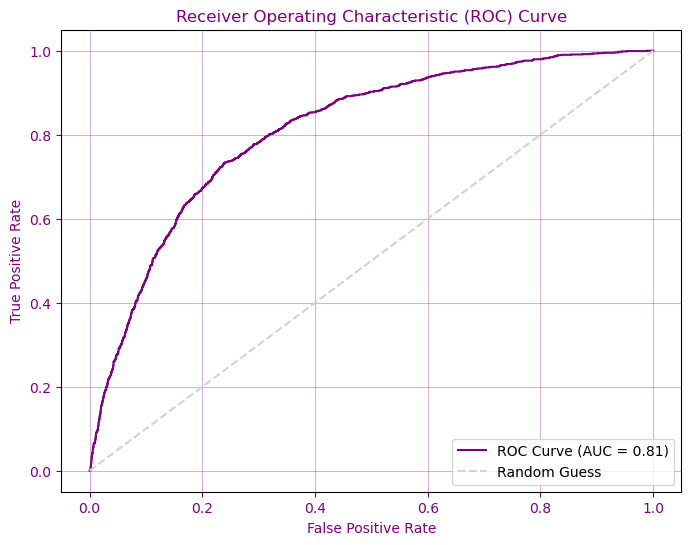

ROC-AUC: 0.81


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Ground truth labels 
ground_truth = test_data["has_pneumonia"].values  # Binary labels (0 or 1)

# Predictions (probabilities from the model)
predictions_probabilities = predictions.flatten()  # Flatten to 1D array if necessary

# 1. Threshold Adjustment
thresholds = np.arange(0.0, 1.1, 0.1)  # Thresholds from 0 to 1 in steps of 0.1
accuracy_scores = []

for threshold in thresholds:
    predicted_classes = (predictions_probabilities >= threshold).astype(int)  # Apply threshold
    accuracy = accuracy_score(ground_truth, predicted_classes)  # Calculate accuracy
    accuracy_scores.append(accuracy)

# Plot accuracy vs. thresholds
plt.figure(figsize=(8, 5))
plt.plot(thresholds, accuracy_scores, marker="o", color="purple", label="Accuracy")
plt.title("Accuracy vs. Threshold", color="purple")
plt.xlabel("Threshold", color="purple")
plt.ylabel("Accuracy", color="purple")
plt.grid(True, color="purple", alpha=0.3)
plt.tick_params(colors="purple")
plt.legend()
plt.show()

# 2. Generating Metrics and Confusion Matrix
optimal_threshold = 0.5  
predicted_classes = (predictions_probabilities >= optimal_threshold).astype(int)  # Apply optimal threshold

# Confusion Matrix
conf_matrix = confusion_matrix(ground_truth, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(ground_truth, predicted_classes, target_names=["No Pneumonia", "Pneumonia"])
print("\nClassification Report:")
print(class_report)

# 3. Visualizing Results
# a. Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=["No Pneumonia", "Pneumonia"], yticklabels=["No Pneumonia", "Pneumonia"])
plt.title("Confusion Matrix Heatmap", color="purple")
plt.xlabel("Predicted Label", color="purple")
plt.ylabel("True Label", color="purple")
plt.tick_params(colors="purple")
plt.show()

# b. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(ground_truth, predictions_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="purple")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess", color="lightgray")
plt.title("Receiver Operating Characteristic (ROC) Curve", color="purple")
plt.xlabel("False Positive Rate", color="purple")
plt.ylabel("True Positive Rate", color="purple")
plt.legend(loc="lower right")
plt.grid(True, color="purple", alpha=0.3)
plt.tick_params(colors="purple")
plt.show()

# Print AUC for reference
print(f"ROC-AUC: {roc_auc:.2f}")
